## Analyze Results from Airtable ##

### Objective ###

By analyzing the result from OpenAlpr API (API), this aims to extract patterns in data that will aid to construct methodoloy(ies) to classify frames into 2 categories.
1. contains license plate of entry vehicle, and is clearly visible, and will get response from API 
2. Does not contain license plate at all; contains irrelevant license plate/vehicle. 

Here, we will only focus on the first 2 criterias of the first category above. Even if a frame contains license plate of entry vehicle and it is clearly visible, that does not garuntee successful response from the API due to other factor such as lightning or focus of the video, which are out of scope for this investiagation.

analyzing uploaded result on airtable to extract patterns among frames that got plate info back from openalpr.

### Data ###
Data was gained by processing 6hrs long video from Safie stream using the following methods.
1. Motion sensing with openCV backgroundSubstractor
2. MobileNet SSD

Out of all frames, ones that contains "car" label, which overlaps with pre-defined area of interest (AoI) were selected, and sent to OpenAlpr API (API).
The data include the result from the API, as well as metadeta from object detection, time etc.

Data is **labeled by hand** in binary fashion. Data that meets the following criterias are labeled as _positive_
1. MobileNet SSD is detecting objects correctly (no weird bounding box)
2. license plate of entry vehicles (to the gate) is clearly visible in the frame

Wether or not a plate was detected by the API was used as label before, but it is not appropriate and not aligned with the objective of this project, as it also included detection such as followings.
1. license plate that belongs to unrelevant vehicles (not entering to the gate)
2. random signs or other objects recognized as license plate

These seems to be the leading cause of low accuracy for previous analyzation.

**Features**<br>
12 features, that are associated with following data will be analyzed in this notebook.

* **BoundingBox**: Bounding box of the detected car. Consists of the coordinates of the box, as well as area.
* **Overlap**: overlapping area of bounding box and area of interest.
* **Motion detection info**: information such as motion score from `cv2.BackgroundSubtractor` and how blurry a picture is.

### Model / Methodology Goal
High recall should be achieved even at the cost of lower precision, for following 2 reasons.
1. cost of missing vehicle(s) is higher than cost of sending little extra numbers of frames to openAlpr
2. extra False Positives can be reduced / removed by further applying additional rules or ML algorithm.

Now we are clear about our goals and intentions, let's get started.

### credit to [this notebook](https://www.kaggle.com/kanncaa1/feature-selection-and-data-visualization)

In [75]:
'''
Given each frame's data and car, 
This will read and assign car numbers to frames, 
and visualize if wanted.
'''
import pandas as pd 
import cv2
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from scipy import stats
import numpy as np
from sklearn import linear_model
from sklearn.decomposition import PCA
import webbrowser
import os
import json
from sklearn import preprocessing

pd.set_option("display.max_columns", 45)

def to_float(lp):
    try:
        return float(lp)
    except ValueError:
        return 0

def to_bool(num):
    return True if num == 1 else False

def to_link(string):
    '''
    given url string, return it in a tag
    '''
    fstring = '<a href={url}>img link</a>'.format(url=string)
    return fstring

def url_to_local_img(img_url, img_dir_path):
    '''convert url string into local image path'''
    img_file_name = img_url.split("?")[0].split('/')[-1]
    return os.path.join(img_dir_path, img_file_name)

#file = 'adjusted_video_box3.csv'
file = 'entry_2_16_9_yolo_hand_labeled.csv'

df = pd.read_csv(file)
print(df.columns)
df.sample(5)

Index(['Unnamed: 0', 'Unnamed: 0.1', 'カメラID', '物体画像', '処理開始時間', 'ナンバープレート',
       'N地域名', 'N分類番号', 'N平仮名等', 'N一連指定番号', 'タイムスタンプ', '物体詳細', 'box_x_min',
       'box_y_min', 'box_x_max', 'box_y_max', 'over_x_min', 'over_y_min',
       'over_x_max', 'over_y_max', 'aoi_x_min', 'aoi_y_min', 'aoi_x_max',
       'aoi_y_max', 'box_height', 'box_width', 'img_url', 'gate_incoming',
       'box_area', 'overlap_area', 'area_of_interest', 'box_height_over_width',
       'frame_area', 'plate_present', 'box_x_center', 'box_y_center',
       'local_img_path', 'motion_score', 'blur_score', 'gate_plate',
       'yolo_x_min', 'yolo_x_max', 'yolo_y_min', 'yolo_y_max', 'yolo_time'],
      dtype='object')


,Unnamed: 0,Unnamed: 0.1,カメラID,物体画像,処理開始時間,ナンバープレート,N地域名,N分類番号,N平仮名等,N一連指定番号,タイムスタンプ,物体詳細,box_x_min,box_y_min,box_x_max,box_y_max,over_x_min,over_y_min,over_x_max,over_y_max,aoi_x_min,aoi_y_min,aoi_x_max,aoi_y_max,box_height,box_width,img_url,gate_incoming,box_area,overlap_area,area_of_interest,box_height_over_width,frame_area,plate_present,box_x_center,box_y_center,local_img_path,motion_score,blur_score,gate_plate,yolo_x_min,yolo_x_max,yolo_y_min,yolo_y_max,yolo_time
666,666,668,entry_2021-02-16_09-01-00.mp4,camera_stored-video_car_65.jpg (https://dl.air...,2021-02-20 02:02,None,NaN,NaN,NaN,None,1.613754e+09,"{""motion_score"": 19140810.0, ""blur_score"": 298...",0.25,0.03,0.79,0.81,0.0,0.0,0.0,0.0,0.1,0.15,0.65,0.95,0.78,0.54,https://orix-demo.s3.amazonaws.com/image-proce...,1.0,0.4212,0.0,0.44,1.444444,1,0.0,0.520,0.420,/home/wataru/Projects/opencv_motion_detection/...,19140810.0,298.582318,0,736.0,815.0,480.0,530.0,0.251582
37,37,37,entry_2021-02-16_09-01-00.mp4,camera_stored-video_car_519.jpg (https://dl.ai...,2021-02-20 02:21,None,NaN,NaN,NaN,None,1.613755e+09,"{""motion_score"": 38135250.0, ""blur_score"": 647...",0.16,0.01,1.01,0.98,0.0,0.0,0.0,0.0,0.1,0.15,0.65,0.95,0.98,0.85,https://orix-demo.s3.amazonaws.com/image-proce...,0.0,0.8245,0.0,0.44,1.152941,1,0.0,0.585,0.495,/home/wataru/Projects/opencv_motion_detection/...,38135250.0,647.720285,0,0.0,0.0,0.0,0.0,0.345935
5,5,5,entry_2021-02-16_09-01-00.mp4,camera_stored-video_car_544.jpg (https://dl.ai...,2021-02-20 02:22,None,NaN,NaN,NaN,None,1.613755e+09,"{""motion_score"": 19215780.0, ""blur_score"": 287...",0.16,0.01,0.53,0.65,0.0,0.0,0.0,0.0,0.1,0.15,0.65,0.95,0.65,0.37,https://orix-demo.s3.amazonaws.com/image-proce...,1.0,0.2368,0.0,0.44,1.756757,1,0.0,0.345,0.330,/home/wataru/Projects/opencv_motion_detection/...,19215780.0,287.335260,0,415.0,499.0,407.0,447.0,0.339385
255,255,255,entry_2021-02-16_09-01-00.mp4,camera_stored-video_car_352.jpg (https://dl.ai...,2021-02-20 02:14,None,NaN,NaN,NaN,None,1.613755e+09,"{""motion_score"": 30782835.0, ""blur_score"": 199...",0.17,-0.00,0.66,0.69,0.0,0.0,0.0,0.0,0.1,0.15,0.65,0.95,0.69,0.49,https://orix-demo.s3.amazonaws.com/image-proce...,1.0,0.3381,0.0,0.44,1.408163,1,0.0,0.415,0.345,/home/wataru/Projects/opencv_motion_detection/...,30782835.0,199.712579,0,510.0,616.0,371.0,429.0,0.266240
570,570,571,entry_2021-02-16_09-01-00.mp4,camera_stored-video_car_132.jpg (https://dl.ai...,2021-02-20 02:04,足立 100 さ 6950,足立,100,さ,6950,1.613754e+09,"{""motion_score"": 58123680.0, ""blur_score"": 855...",0.11,-0.00,0.62,0.79,0.0,0.0,0.0,0.0,0.1,0.15,0.65,0.95,0.80,0.51,https://orix-demo.s3.amazonaws.com/image-proce...,1.0,0.4029,0.0,0.44,1.568627,1,1.0,0.365,0.395,/home/wataru/Projects/opencv_motion_detection/...,58123680.0,855.210702,1,452.0,567.0,474.0,535.0,0.253712


You can see that there are lots of unrelated columns present in the dataframe. Let's pick the columns that are 
relevant for this analysis.

**Couple things to consider** 
* `処理開始時間` column shows datetime of the frame, but we can convert this into time column to extract possible trend in data, under name of `hour` column.
* 3 possible label columns exist.
    * `gate_incoming`:primary label column. Shows weather the license plate of entry vehicle is present in the frame.
    * `plate_present`:existence of recognized plate by API, regardless of vehicle/ entry.
    * `gate_plate`: out of all entry vehicles with visible plate (`gate_incoming`), ones that plate was recognized by the API.

We will primarily look at the first label.

In [2]:
df["ナンバープレート"] = df["ナンバープレート"].str.strip()
df['処理開始時間'] = pd.to_datetime(df['処理開始時間'])
df['hour'] = df['処理開始時間'].dt.hour


feature_candidate_columns = ['hour','box_x_min','box_y_min', 'box_x_max', 'box_y_max',
        'over_x_min', 'over_y_min','over_x_max', 'over_y_max', 
        'aoi_x_min', 'aoi_y_min', 'aoi_x_max','aoi_y_max', 
        'box_height', 'box_width','box_area', 'overlap_area', 'area_of_interest', 'box_height_over_width',
        'frame_area', 'box_x_center', 'box_y_center',
        'motion_score', 'blur_score']

image_columns = ['img_url', 'local_img_path']


'''
yolo_columns  = ['処理開始時間', 'ナンバープレート','タイムスタンプ','box_x_min',
       'box_y_min', 'box_x_max', 'box_y_max', 'over_x_min', 'over_y_min',
       'over_x_max', 'over_y_max', 'aoi_x_min', 'aoi_y_min', 'aoi_x_max',
       'aoi_y_max', 'box_height', 'box_width', 'img_url', 'gate_incoming',
       'box_area', 'overlap_area', 'area_of_interest', 'box_height_over_width',
       'frame_area', 'plate_present', 'box_x_center', 'box_y_center',
       'local_img_path', 'motion_score', 'blur_score', 'gate_plate',
       'yolo_x_min', 'yolo_x_max', 'yolo_y_min', 'yolo_y_max', 'yolo_time']
'''
label_columns = ['plate_present', 'gate_incoming', 'gate_plate']

## select columns that are relevant to data analysis purpose
x = df[feature_candidate_columns]

y = df[label_columns]
#df.drop_duplicates(subset=['img_url'], inplace=True, keep=False)

x.head()


# df['box_area'] = (df['box_x_max'] - df['box_x_min'])*(df['box_y_max'] - df['box_y_min'])
# df['overlap_area'] = (df['over_x_max'] - df['over_x_min'])*(df['over_y_max'] - df['over_y_min'])
# df['area_of_interest'] = (df['aoi_x_max'] - df['aoi_x_min'])*(df['aoi_y_max'] - df['aoi_y_min'])
# df['box_height_over_width'] = df['box_height'] / df['box_width']
# # checking this
# #df['overlap_right_buttom'] = df[(df['box_x_min'] < df['aoi_x_min']) & (df['aoi_x_min'] < df['aoi_x_max'])]
# df['frame_area'] = 1
# df.loc[df["ナンバープレート"] != "None", 'plate_present'] = 1
# df.loc[df["ナンバープレート"] == "None", 'plate_present'] = 0


# df['box_x_center'] = (df['box_x_min']+df['box_x_max'])/2
# df['box_y_center'] = (df['box_y_min']+df['box_y_max'])/2

# local_img_path = 'trucks'
# df['local_img_path'] = df['img_url'].map(lambda x: url_to_local_img(x, local_img_path))
# print(df['local_img_path'])
# df['motion_score'] = ''
# df['blur_score'] = ''

# for ind, row in df.iterrows():
#     dic = json.loads(row['物体詳細'])
#     for k, v in dic.items():
#         df.loc[ind, k] = v

# # drop value where gate_incoming == ?
# print(df['gate_incoming'].value_counts())
# df = df[df['gate_incoming'] != "?"]
# df = df[df['gate_incoming'] != "-"]

# df['gate_incoming'] = df['gate_incoming'].astype(float)

# df['gate_plate'] = 0
# df.loc[(df['plate_present'] == 1) & (df['gate_incoming'] ==1 ), 'gate_plate'] = 1

# df.to_csv("hand_labeled_table.csv")

,hour,box_x_min,box_y_min,box_x_max,box_y_max,over_x_min,over_y_min,over_x_max,over_y_max,aoi_x_min,aoi_y_min,aoi_x_max,aoi_y_max,box_height,box_width,box_area,overlap_area,area_of_interest,box_height_over_width,frame_area,box_x_center,box_y_center,motion_score,blur_score
0,2,0.14,0.11,0.93,0.98,0.0,0.0,0.0,0.0,0.1,0.15,0.65,0.95,0.87,0.78,0.6873,0.0,0.44,1.115385,1,0.535,0.545,20699370.0,282.295589
1,2,0.13,0.05,0.82,0.89,0.0,0.0,0.0,0.0,0.1,0.15,0.65,0.95,0.84,0.69,0.5796,0.0,0.44,1.217391,1,0.475,0.470,24408345.0,519.447832
2,2,0.11,-0.01,0.50,0.51,0.0,0.0,0.0,0.0,0.1,0.15,0.65,0.95,0.52,0.39,0.2028,0.0,0.44,1.333333,1,0.305,0.250,20460180.0,235.039267
3,2,0.12,0.03,0.57,0.56,0.0,0.0,0.0,0.0,0.1,0.15,0.65,0.95,0.53,0.45,0.2385,0.0,0.44,1.177778,1,0.345,0.295,19735725.0,419.717096
4,2,0.16,0.01,0.54,0.65,0.0,0.0,0.0,0.0,0.1,0.15,0.65,0.95,0.64,0.39,0.2432,0.0,0.44,1.641026,1,0.350,0.330,19215780.0,287.335260


Number of entry plates:  475
Number of non entry plate / no plate :  285


/home/wataru/Projects/opencv_motion_detection/motion_env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


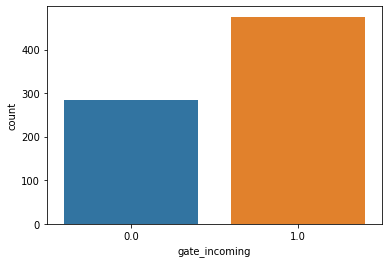

In [4]:
ax = sns.countplot(y['gate_incoming'],label="Entry Vehicle Plate Count")
B, M = y['gate_incoming'].value_counts()
print('Number of entry plates: ',B)
print('Number of non entry plate / no plate : ',M)

We see that the 2 classes in the label is slightly unbalanced, therefore this needs to be addressed when training the predictive model.

Before proceeding to feature selection, we'd like to take a brief look at each feature statistically, and how it relates to the label and other features.
Below is rough ideas of each features. We can see that most of the features' value fit between 0~1, as they are coordinates, length, or area in proportion to the frame size. 
There are however other features that do not fit in the range, such as `blur_score`. These needs to be normalized/standardized, in order to be compared with other features in visualization.

In [3]:
x.describe()

,hour,box_x_min,box_y_min,box_x_max,box_y_max,over_x_min,over_y_min,over_x_max,over_y_max,aoi_x_min,aoi_y_min,aoi_x_max,aoi_y_max,box_height,box_width,box_area,overlap_area,area_of_interest,box_height_over_width,frame_area,box_x_center,box_y_center,motion_score,blur_score
count,760.0,760.000000,760.000000,760.000000,760.000000,760.0,760.0,760.0,760.0,760.0,7.600000e+02,7.600000e+02,7.600000e+02,760.000000,760.000000,760.000000,760.0,7.600000e+02,760.000000,760.0,760.000000,760.000000,7.600000e+02,760.000000
mean,2.0,0.094789,0.016211,0.599632,0.645447,0.0,0.0,0.0,0.0,0.1,1.500000e-01,6.500000e-01,9.500000e-01,0.629395,0.504658,0.362270,0.0,4.400000e-01,1.298357,1.0,0.347211,0.330829,3.520832e+07,607.210934
std,0.0,0.115188,0.050084,0.235919,0.256250,0.0,0.0,0.0,0.0,0.0,2.777385e-17,1.110954e-16,1.110954e-16,0.250883,0.217285,0.260347,0.0,1.110954e-16,0.402276,0.0,0.150423,0.135396,1.457775e+07,261.417580
min,2.0,-0.010000,-0.020000,0.100000,0.110000,0.0,0.0,0.0,0.0,0.1,1.500000e-01,6.500000e-01,9.500000e-01,0.110000,0.080000,0.012000,0.0,4.400000e-01,0.303571,1.0,0.055000,0.055000,1.900158e+07,33.340295
25%,2.0,0.010000,0.000000,0.480000,0.480000,0.0,0.0,0.0,0.0,0.1,1.500000e-01,6.500000e-01,9.500000e-01,0.470000,0.380000,0.189750,0.0,4.400000e-01,1.042560,1.0,0.250000,0.240000,2.375892e+07,420.827417
50%,2.0,0.060000,0.000000,0.560000,0.660000,0.0,0.0,0.0,0.0,0.1,1.500000e-01,6.500000e-01,9.500000e-01,0.640000,0.480000,0.298900,0.0,4.400000e-01,1.274241,1.0,0.315000,0.340000,3.086622e+07,572.340170
75%,2.0,0.140000,0.010000,0.770000,0.860000,0.0,0.0,0.0,0.0,0.1,1.500000e-01,6.500000e-01,9.500000e-01,0.820000,0.610000,0.467625,0.0,4.400000e-01,1.469697,1.0,0.466250,0.440000,4.357026e+07,756.337559
max,2.0,0.700000,0.500000,1.020000,1.020000,0.0,0.0,0.0,0.0,0.1,1.500000e-01,6.500000e-01,9.500000e-01,1.020000,1.040000,1.040300,0.0,4.400000e-01,4.937500,1.0,0.845000,0.750000,1.008474e+08,2367.206674


### Feature Visualization

We will use seaborn's violin and swarm plot of the features, and group 10 features into 1 plot for clearity.
Remember that we need to normalize or standardize the features before. Let's start with visualizing distribution of such features, so we can decide which normalization technique to use.

**Columns to Noralize**
* `blur_score`
* `motion_score`
* `box_height_over_width`

In [58]:
mm =  preprocessing.MinMaxScaler()

x['blur_score_norm'] = mm.fit_transform(x['blur_score'].values.reshape(-1,1))
x['motion_score_norm'] = mm.fit_transform(x['motion_score'].values.reshape(-1,1))
x['box_height_over_width_norm'] = mm.fit_transform(x['box_height_over_width'].values.reshape(-1,1))

# drop features with 0 std
plt_feature_cols = x.columns[x.std() > 0.01]
plt_feature_cols = plt_feature_cols.drop(['motion_score', 'blur_score', 'box_height_over_width'])

<ipython-input-58-32fb3df4fc24>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['blur_score_norm'] = mm.fit_transform(x['blur_score'].values.reshape(-1,1))
<ipython-input-58-32fb3df4fc24>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['motion_score_norm'] = mm.fit_transform(x['motion_score'].values.reshape(-1,1))
<ipython-input-58-32fb3df4fc24>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'box_x_min'),
  Text(1, 0, 'box_y_min'),
  Text(2, 0, 'box_x_max'),
  Text(3, 0, 'box_y_max'),
  Text(4, 0, 'box_height'),
  Text(5, 0, 'box_width'),
  Text(6, 0, 'box_area'),
  Text(7, 0, 'box_x_center'),
  Text(8, 0, 'box_y_center'),
  Text(9, 0, 'blur_score_norm'),
  Text(10, 0, 'motion_score_norm'),
  Text(11, 0, 'box_height_over_width_norm')])

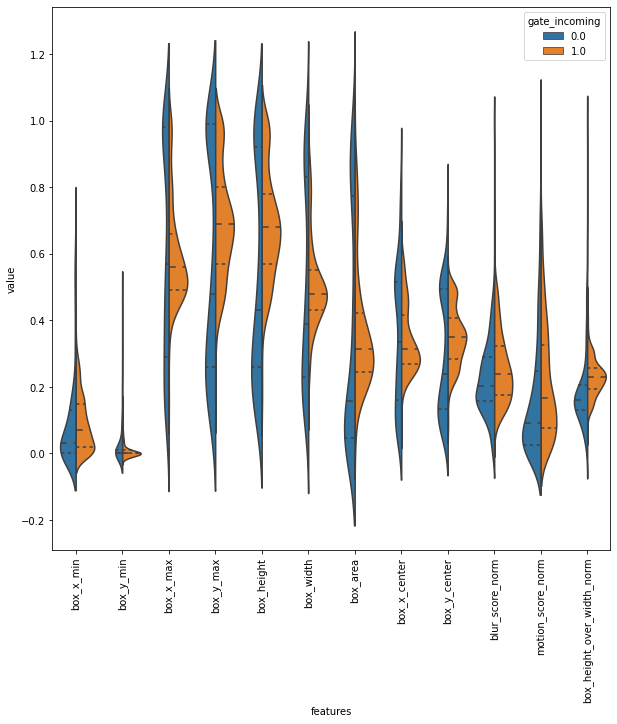

In [59]:
data_features = x[plt_feature_cols]
data_label = y['gate_incoming']

data = pd.concat([data_label,data_features],axis=1)
data = pd.melt(data,id_vars="gate_incoming",
                    var_name="features",
                    value_name='value')


plt.figure(figsize=(10,10))
sns.violinplot(x="features", y="value", hue="gate_incoming", data=data,split=True, inner="quart")
plt.xticks(rotation=90)

Interpreting the data above based on 2 criterias.

**Class Separation**

Peaks of `box_x_max` and `box_width` distributions are separated by class nicely.
`box_y_max`, `box_height`,`box_area` as well as `box_x/y_center` are separated, with some overlap at upper end of the distribution. 
`box_height_over_width_norm` column's median is separated with some overlap.
Other columns' distributions are mostly overlapping, hence won't give much information about class separation.

**Possible Correlation**

Following features are seems to have some correlations to each other.
* `box_y_max`, `box_height`
* `box_x_max`, `box_width`

It make sense, since these features are semantically related as well.

We'll use jointplot to visualize the relationship between these combinations of features, and take a deeper look below.

[jointplot annotation with scipy.stats](https://stackoverflow.com/questions/64573067/seaborn-jointplot-annotate-with-correlation)

**Jointplot**

Text(0.1, 0.9, '$\\rho = 0.981, p = 0.000$')

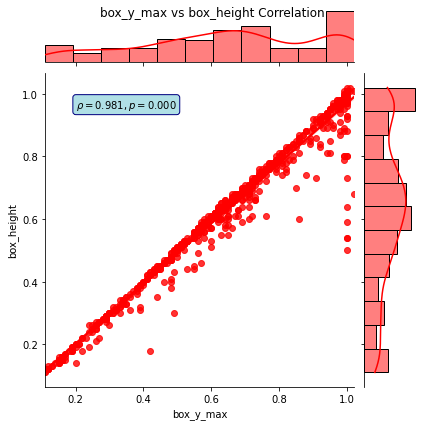

In [6]:
j = sns.jointplot(x=x['box_y_max'], y=x['box_height'], kind="reg", color="red")
j.fig.suptitle("box_y_max vs box_height Correlation")
r, p = stats.pearsonr(x['box_y_max'], x['box_height'])
j.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})

From the graph and close-to-1 pearsonr value, these features are highly correlated.

Text(0.1, 0.9, '$\\rho = 0.874, p = 0.000$')

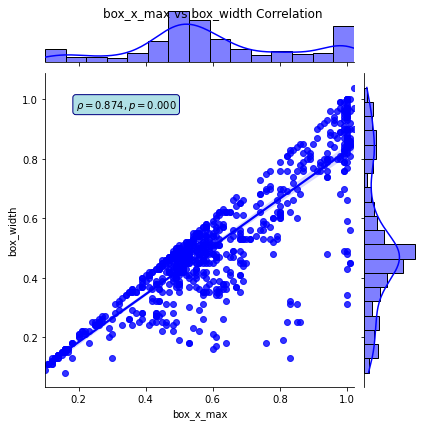

In [7]:
j = sns.jointplot(x=x['box_x_max'], y=x['box_width'], kind="reg", color="blue")
j.fig.suptitle("box_x_max vs box_width Correlation")
r, p = stats.pearsonr(x['box_x_max'], x['box_width'])
j.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})

Although not as high as previous feature combination, these 2 features also seems to be correlated.

Now let's take a look at larger number of feature comparison.
We'll use pair grid plot.

**Pair Grid**

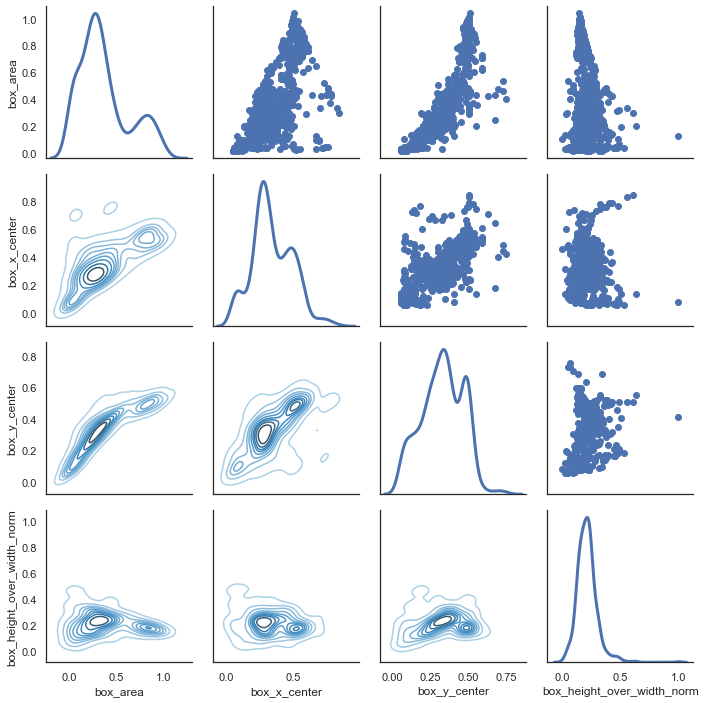

In [10]:
sns.set(style="white")
grid_cols = ['box_area', 'box_x_center', 'box_y_center', 'box_height_over_width_norm']
df = x.loc[:,grid_cols]
g = sns.PairGrid(df, diag_sharey=False)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_upper(plt.scatter)
g.map_diag(sns.kdeplot, lw=3)

For the rest of features, there are not obvious correlation present, although `box_area` and `box_y_center` might be somewhat correlated.

Let's take a look at the correlations of all feature combinations, using heatmap.

<AxesSubplot:>

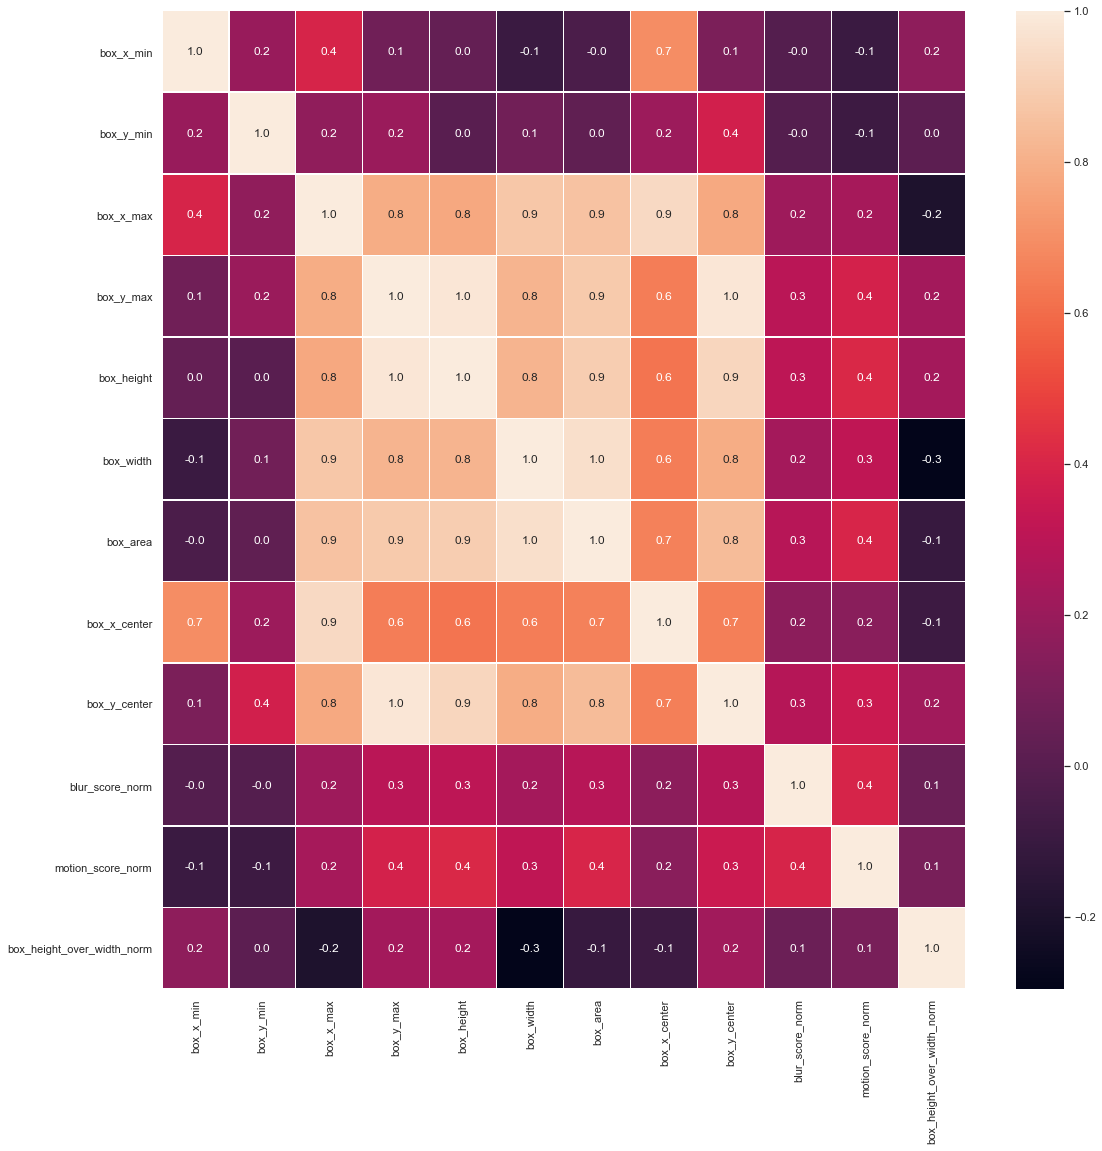

In [11]:
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(x[plt_feature_cols].corr(), annot=True, linewidths=.5, fmt= '.1f', ax=ax)

Finally, let's take a look at each features distribution in relations to class separation again, this time using swarm plot. 
It is easier to observe variance and outliers with this plot.

**Swarm Plot**

/home/wataru/Projects/opencv_motion_detection/motion_env/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 92.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/wataru/Projects/opencv_motion_detection/motion_env/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 26.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/wataru/Projects/opencv_motion_detection/motion_env/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 68.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/wataru/Projects/opencv_motion_detection/motion_env/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 5.1% of the points cannot be placed; you may want to decrease the size of t

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 [Text(0, 0, 'plate_present'),
  Text(1, 0, 'gate_plate'),
  Text(2, 0, 'box_x_min'),
  Text(3, 0, 'box_y_min'),
  Text(4, 0, 'box_x_max'),
  Text(5, 0, 'box_y_max'),
  Text(6, 0, 'box_height'),
  Text(7, 0, 'box_width'),
  Text(8, 0, 'box_area'),
  Text(9, 0, 'box_x_center'),
  Text(10, 0, 'box_y_center'),
  Text(11, 0, 'blur_score_norm'),
  Text(12, 0, 'motion_score_norm'),
  Text(13, 0, 'box_height_over_width_norm')])

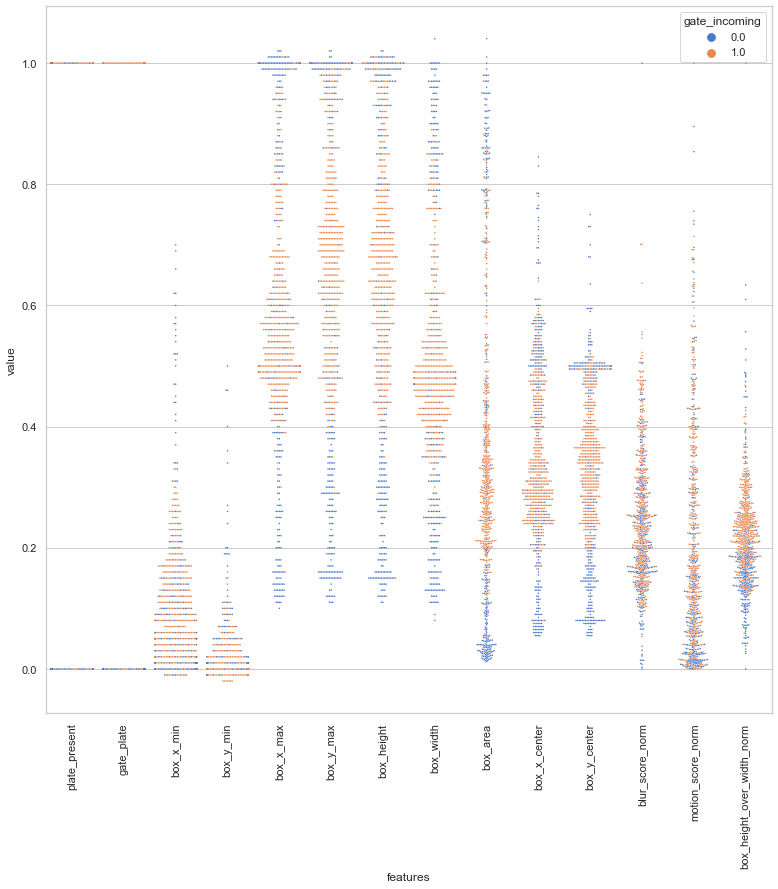

In [12]:
sns.set(style="whitegrid", palette="muted")
data_features = x[plt_feature_cols]
data_label = y['gate_incoming']
data = pd.concat([y,data_features],axis=1)
data = pd.melt(data,id_vars="gate_incoming",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(13,13))
sns.swarmplot(x="features", y="value", hue="gate_incoming", data=data, size=1.5)
plt.xticks(rotation=90)

We can get more detailed picture in this plot than violin plot earlier. 
Following features, seems to be a good features for separating the 2 classes.
* `box_x_max` 
* `box_y_max`
* `box_height`
* `box_width`
* `box_x_center`
* `box_y_center`
* `box_area` 

On the other hand `box_x/y_min` or `blur_score(norm)`, along with other unmentioned features appeared to be useless as a predictor.

### Feature Selection

By visualizing the data, we have rough idea of what each feature looks like and how they're related to each other and label.

It is time to investigate what features combinations makes the best predictor. We'll take a look at following 4 mehtods of feature selection.
1. Selection based on correlation analysis from the visualization
2. Univariate Feature Selection
3. Recursive Feature Elimination (RFE)
4. Recursive Feature Elimination with Cross Validation (RFECV)
5. Tree based feature selection


We will use Support Vector Machine for training our classifier.

### Selection based on Correlation

Looking at the heatmap, following combinations of features have strong correlation.
* `box_x_center`, `box_x_max`, `box_area`
* `box_y_center`, `box_y_max`, `box_area`
* `box_height`, `box_y_max`

Now looking at the swarm plot, `box_x/y_max`, `box_width/height`, `box_area` and `box_height_over_width` seems to have good separation power. 

Considerning these facters, I've picked `box_x_max`, `box_y_max`, and `box_height_over_widht`.

,box_x_max,box_y_max,box_height_over_width_norm
count,760.000000,760.000000,760.000000
mean,0.599632,0.645447,0.214674
std,0.235919,0.256250,0.086811
min,0.100000,0.110000,0.000000
25%,0.480000,0.480000,0.159473
50%,0.560000,0.660000,0.209470
75%,0.770000,0.860000,0.251649
max,1.020000,1.020000,1.000000


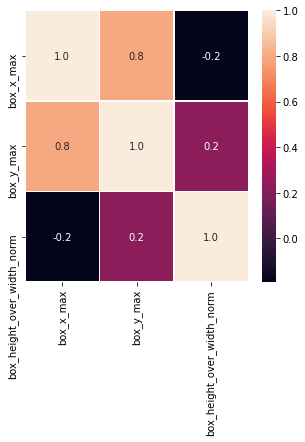

In [8]:
corr_feature_cols = ['box_x_max', 'box_y_max', 'box_height_over_width_norm']
corr_features = x[corr_feature_cols]

#correlation map
f,ax = plt.subplots(figsize=(5, 5))
sns.heatmap(corr_features.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

corr_features.describe()

We can see that we don't have any more of strongly correlataed features.

Now let's see how the model performs on this set of features.

Accuracy is:  0.8991228070175439
recall:  0.9343065693430657
precision: 0.9014084507042254


<AxesSubplot:>

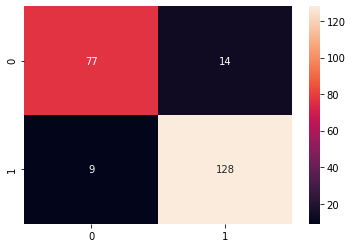

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.metrics import accuracy_score

# split data train 70 % and test 30 %
x_train, x_test, y_train, y_test = train_test_split(corr_features, y['gate_incoming'], test_size=0.3, random_state=42)

#random forest classifier with n_estimators=10 (default)
clf_svm = SVC()      
clr_svm = clf_svm.fit(x_train,y_train)

ac = accuracy_score(y_test,clf_svm.predict(x_test))
print('Accuracy is: ',ac)
cm = confusion_matrix(y_test,clf_svm.predict(x_test))
recall = cm[1][1]/(cm[1][0]+cm[1][1])
precision = cm[1][1]/(cm[0][1]+cm[1][1])
print("recall: ", recall)
print("precision:", precision)
sns.heatmap(cm,annot=True,fmt="d")

As you can see, we've achieved 89.9% accuracy, with higher recall than precision.
Let us take a look at the images of False Negative cases.

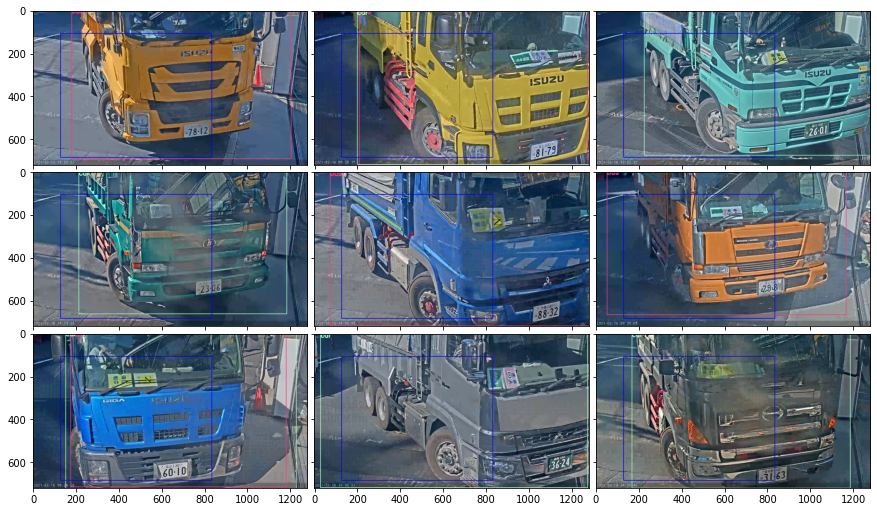

In [55]:
# get image path of false negatives
x_test_data = x_test.copy()
x_test_data.loc[:, 'pred'] = clf_svm.predict(x_test)
test_data = pd.concat((x_test_data, y_test), axis=1)
FN = test_data.loc[(test_data['gate_incoming'] == 1) & (test_data['pred'] == 0), :]

FN_imgs = df.loc[FN.index, 'local_img_path']

def plot_images(FN_imgs, nrows_ncols):
    fig = plt.figure(figsize=(15., 15.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=nrows_ncols,  # creates 2x2 grid of axes
                     axes_pad=0.1,  # pad between axes in inch.
                     )

    for ax, im in zip(grid, FN_imgs.to_list()):
        img = plt.imread(im)
        ax.imshow(img)
    
    plt.show()
    
plot_images(FN_imgs, (3,3))

Let's see if we can better this result with other feature selection methods.

### Univariate Feature Selection

In this method, we select top best n number of features based on a choosen feature scoring method. Let's pick 5 features here intuitively, just to demonstrate.
It is possible however, to try different numbers of features.


In [60]:
from numpy import set_printoptions
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

label_col = 'gate_incoming'

data = x[plt_feature_cols]
label = y[label_col]

def univariate(X, y):
    '''Given x and y data, perform univariate analysis and return dictionary of features name and its scores'''
    test = SelectKBest(score_func=f_classif, k=5)
    fit = test.fit(X, y)
    # summarize scores
    set_printoptions(precision=3)
    feature_score_dict = {k:v for k, v in zip(feature_cols, fit.scores_)}
    feature_scores = dict(sorted(feature_score_dict.items(), key=lambda item: item[1], reverse=True))
    # summarize scores
    print("selected columns:", list(feature_scores.keys())[:5])
    set_printoptions(precision=3)
    return fit

# because of its nature, we'll run this couple times to take average score and decide which are 
# the most effective predictor
select_feature = univariate(data, label)

selected columns: ['over_x_min', 'aoi_y_max', 'box_y_max', 'box_y_min', 'aoi_x_min']


We can see that these are very different combination of features selected.
Let's see how it predicts.

Accuracy is:  0.8640350877192983
recall:  0.9051094890510949
precision: 0.8732394366197183


<AxesSubplot:>

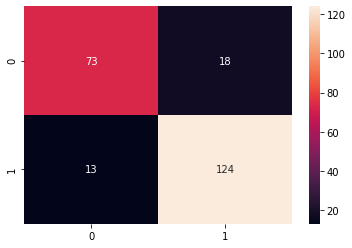

In [61]:
x_train, x_test, y_train, y_test = train_test_split(data, label, test_size=0.3, random_state=42)

x_train_uni = select_feature.transform(x_train)
x_test_uni = select_feature.transform(x_test)


#random forest classifier with n_estimators=10 (default)
clf_svm = SVC()      
clr_svm = clf_svm.fit(x_train_uni,y_train)

ac = accuracy_score(y_test,clf_svm.predict(x_test_uni))
print('Accuracy is: ',ac)
cm = confusion_matrix(y_test,clf_svm.predict(x_test_uni))
recall = cm[1][1]/(cm[1][0]+cm[1][1])
precision = cm[1][1]/(cm[0][1]+cm[1][1])
print("recall: ", recall)
print("precision:", precision)
sns.heatmap(cm,annot=True,fmt="d")

Hmm this looks way worse than hand selected features. Both recall and precision are lower, and both classes are missclassified.

Let's take a look at Recursive Feature Elimination.

### Recursive Feature Elimination (RFE)

In [RFE](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html), an estimator of choice (RandomForest here) is used to "score" or assign weight to each feature, and least perfoming one is removed.
This process is repeated recursively until the number of features are reduced to specified value.
Here we pick 5 features.

In [65]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
# Create the RFE object and rank each pixel
print("selecting 5 out of {} features".format(x_train.shape[1]))
clf_svm_3 = RandomForestClassifier()      
rfe = RFE(estimator=clf_svm_3, n_features_to_select=5, step=1)
rfe = rfe.fit(x_train, y_train)
print('Chosen best 5 feature by rfe:',x_train.columns[rfe.support_])

selecting 5 out of 12 features
Chosen best 5 feature by rfe: Index(['box_x_max', 'box_height', 'box_area', 'box_y_center',
       'box_height_over_width_norm'],
      dtype='object')


This is different combination of features. Let's take a look at performance on SVM.

Accuracy is:  0.9035087719298246
recall:  0.9562043795620438
precision: 0.891156462585034


<AxesSubplot:>

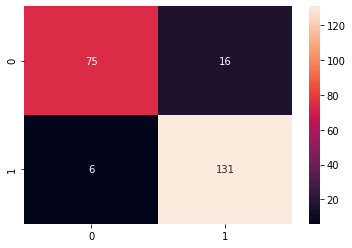

In [66]:
x_train_rfe = rfe.transform(x_train)
x_test_rfe = rfe.transform(x_test)

#random forest classifier with n_estimators=10 (default)
clf_svm = SVC()      
clr_svm = clf_svm.fit(x_train_rfe,y_train)

ac = accuracy_score(y_test,clf_svm.predict(x_test_rfe))
print('Accuracy is: ',ac)
cm = confusion_matrix(y_test,clf_svm.predict(x_test_rfe))
recall = cm[1][1]/(cm[1][0]+cm[1][1])
precision = cm[1][1]/(cm[0][1]+cm[1][1])
print("recall: ", recall)
print("precision:", precision)
sns.heatmap(cm,annot=True,fmt="d")

Wow! this is better than the past 2 methods we've tried. Both lower FN and FP with accuracy of approx. 90%

Now with this method, we needed to manually choose number of featurs. Next method will also choose 

### Recursive Feature Elimination with Cross Validation and Random Forest classification

[This method](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html), based on RFE is also capable of choosing the best number of features from the given set of features.

In [67]:
from sklearn.feature_selection import RFECV

# The "accuracy" scoring is proportional to the number of correct classifications
clf_rf_4 = RandomForestClassifier() 
rfecv = RFECV(estimator=clf_rf_4, step=1, cv=5,scoring='accuracy')   #5-fold cross-validation
rfecv = rfecv.fit(x_train, y_train)

print('Optimal number of features :', rfecv.n_features_)
print('Best features :', x_train.columns[rfecv.support_])

Optimal number of features : 12
Best features : Index(['box_x_min', 'box_y_min', 'box_x_max', 'box_y_max', 'box_height',
       'box_width', 'box_area', 'box_x_center', 'box_y_center',
       'blur_score_norm', 'motion_score_norm', 'box_height_over_width_norm'],
      dtype='object')


So... it looks like using all 12 features is the best way for getting best accuracy... Let's see.

Accuracy is:  0.9254385964912281
recall:  0.9781021897810219
precision: 0.9054054054054054


<AxesSubplot:>

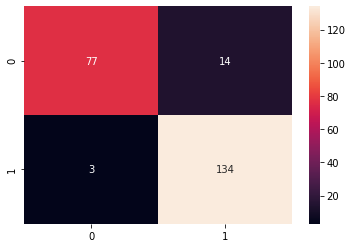

In [68]:
x_train_rfe_cv = rfecv.transform(x_train)
x_test_rfe_cv = rfecv.transform(x_test)

#random forest classifier with n_estimators=10 (default)
clf_svm = SVC()      
clr_svm = clf_svm.fit(x_train_rfe_cv,y_train)

ac = accuracy_score(y_test,clf_svm.predict(x_test_rfe_cv))
print('Accuracy is: ',ac)
cm = confusion_matrix(y_test,clf_svm.predict(x_test_rfe_cv))
recall = cm[1][1]/(cm[1][0]+cm[1][1])
precision = cm[1][1]/(cm[0][1]+cm[1][1])
print("recall: ", recall)
print("precision:", precision)
sns.heatmap(cm,annot=True,fmt="d")

Out of all the methods, this is the best result with roughly 92% accuracy, with high recall.

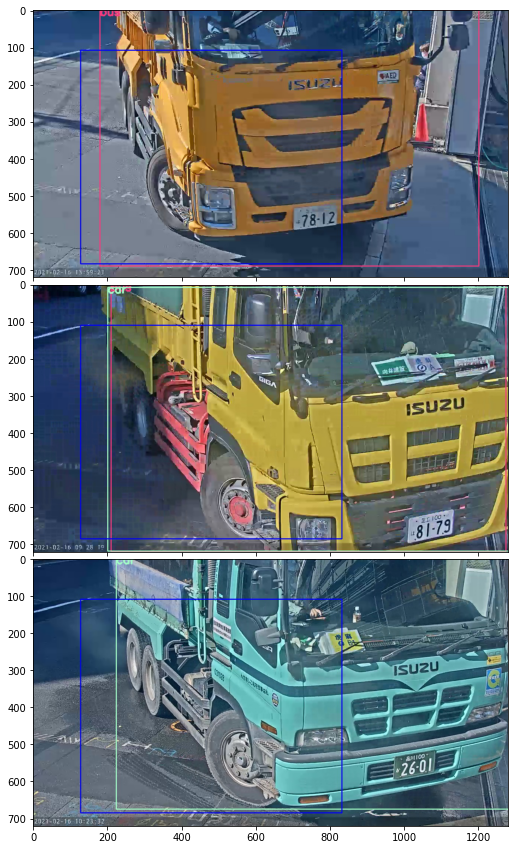

In [69]:
# plotting FN's case image
# get image path of false negatives
x_test_data = x_test.copy()
x_test_data.loc[:, 'pred'] = clf_svm.predict(x_test)
test_data = pd.concat((x_test_data, y_test), axis=1)
FN = test_data.loc[(test_data['gate_incoming'] == 1) & (test_data['pred'] == 0), :]

plot_images(FN_imgs, (3,1))

Let's look at how numbers of features affect accuracy.

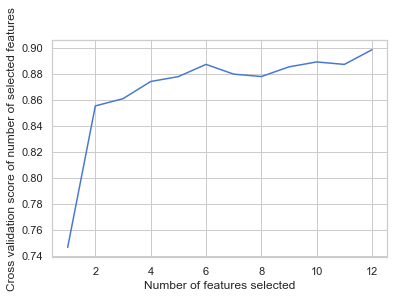

In [63]:

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score of number of selected features")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

While we uncovered that the RFECV method was the most powerful method to select feature in this case, we don't have a way of scoring which features hold the most importance.

Inside [sklearn's RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), there is attribute called `feature_importance`. This can be used to score each feature.
**To use feature_importance method, in training data there should not be correlated features. Random forest choose randomly at each iteration, therefore sequence of feature importance list can change.**

Also take a look at [this post from sklearn about this method](https://scikit-learn.org/stable/glossary.html#term-cross-validation-estimator)

Feature ranking:
1. feature 3 (0.130361)
2. feature 2 (0.127130)
3. feature 4 (0.109723)
4. feature 11 (0.109157)
5. feature 5 (0.107747)
6. feature 6 (0.104343)
7. feature 8 (0.097072)
8. feature 7 (0.064837)
9. feature 9 (0.049149)
10. feature 10 (0.039505)
11. feature 0 (0.032496)
12. feature 1 (0.028480)
[0.143 0.113 0.132 0.096 0.11  0.118 0.116 0.062 0.032 0.025 0.024 0.028]


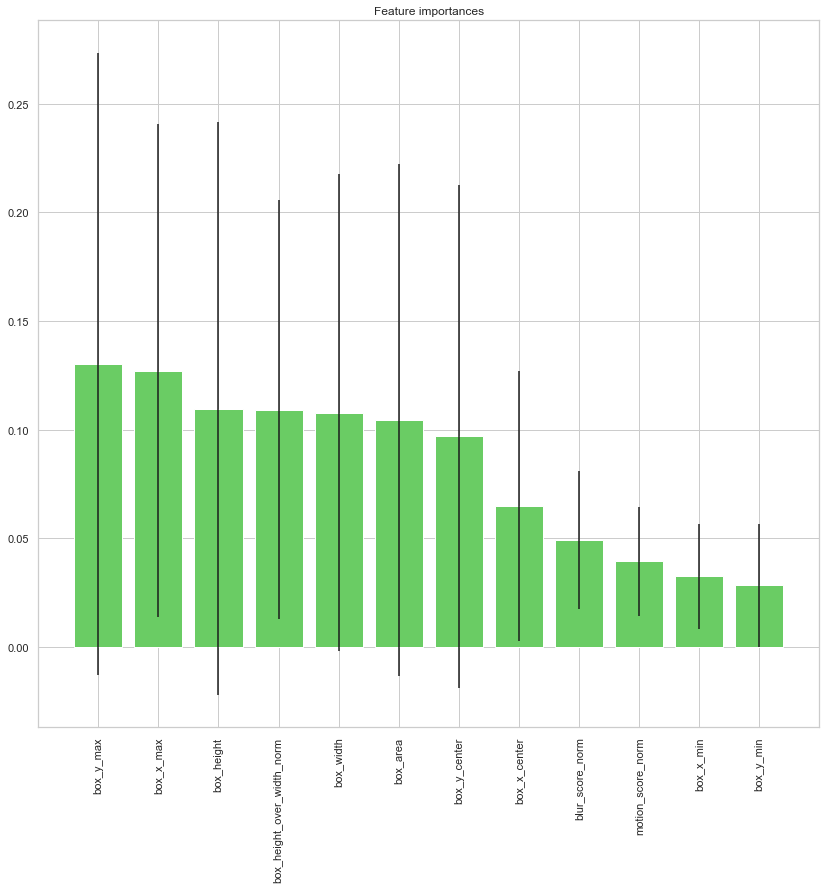

In [67]:
clf_rf_5 = RandomForestClassifier()      
clr_rf_5 = clf_rf_5.fit(x_train,y_train)
importances = clr_rf_5.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_rf_5.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(x_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
print(std[indices])
plt.figure(1, figsize=(14, 13))
plt.title("Feature importances")
plt.bar(range(x_train.shape[1]), importances[indices],
       color="g", yerr=std[indices], align="center")
plt.xticks(range(x_train.shape[1]), x_train.columns[indices],rotation=90)
plt.xlim([-1, x_train.shape[1]])
plt.show()

## Feature Extraction (PCA)

We'll try feature extraction, using Principal Component Analysis.
We need to normalize the data before applying PCA for its better performance.



Text(0, 0.5, 'explained_variance_ratio_')

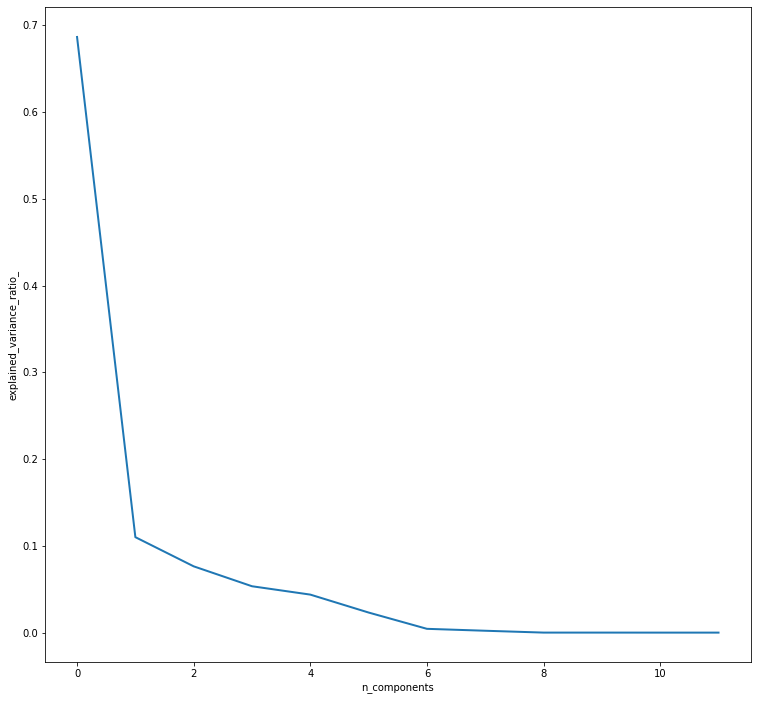

In [90]:
# split data into train and test
x_train, x_test, y_train, y_test = train_test_split(x[feature_cols],y['gate_incoming'],
                                                    test_size=0.3, random_state=42)

# normalization
x_train_N = (x_train - x_train.mean())/(x_train.max() - x_train.min())
x_test_N = (x_test - x_test.mean())/(x_test.max() - x_test.min())
x_train_N = x_train_N.replace([np.inf, -np.inf], np.nan).dropna(axis=1)
x_test_N = x_test_N.replace([np.inf, -np.inf], np.nan).dropna(axis=1)
pca = PCA()
pca.fit(x_train_N)

plt.figure(1, figsize=(14, 13))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_ratio_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_ratio_')

We can see that it's good idea to choose 1~2 numbers of components for max predictive power and lowest numbers of features.



## Conclusion

### What this is.
While this was a comprehensive analysis of the data, and exploration of visualization and feature selection methods, it is not a complete or perfecdt methodologies that can be generalized into all alalyzation task.
Hence this should be taken just as a reference material.

### License Plate Project wise...
Successfully constructed a SVM model to predict / select frames that contains entry vehicle(s) that has visible licence plate, of a accuracy around 90% and recall of 97.81%.
**Where to go from here...**<br>
In terms of this project, collect more data to verify the accuracy and effectiveness of this model in real life. 
In order to increase accuracy while keeping high recall, one might consider to apply Yolov4 on predicted positive data to refine the result by recognizing the existence of license plate in the frame.

1. Collect & label more data
2. analze further by applying yolov4
